In [ ]:
!pip3 install shap

In [ ]:
# id: 집 고유아이디
# date: 집이 팔린 날짜 
# price: 집 가격 (타겟변수)
# bedrooms: 주택 당 침실 개수
# bathrooms: 주택 당 화장실 개수
# floors: 전체 층 개수
# waterfront: 해변이 보이는지 (0, 1)
# condition: 집 청소상태 (1~5)
# grade: King County grading system 으로 인한 평점 (1~13)
# yr_built: 집이 지어진 년도
# yr_renovated: 집이 리모델링 된 년도
# zipcode: 우편번호
# lat: 위도
# long: 경도

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
os.getcwd()

'/Users/keem/Desktop/알고리즘'

In [10]:
data = pd.read_csv("./kc_house_data.csv") 
data.head()

id             date     price  bedrooms  bathrooms  floors  \
0  7129300520  20141013T000000  221900.0         3       1.00     1.0   
1  6414100192  20141209T000000  538000.0         3       2.25     2.0   
2  5631500400  20150225T000000  180000.0         2       1.00     1.0   
3  2487200875  20141209T000000  604000.0         4       3.00     1.0   
4  1954400510  20150218T000000  510000.0         3       2.00     1.0   

   waterfront  condition  grade  yr_built  yr_renovated  zipcode      lat  \
0           0          3      7      1955             0    98178  47.5112   
1           0          3      7      1951          1991    98125  47.7210   
2           0          3      6      1933             0    98028  47.7379   
3           0          5      7      1965             0    98136  47.5208   
4           0          3      8      1987             0    98074  47.6168   

      long  
0 -122.257  
1 -122.319  
2 -122.233  
3 -122.393  
4 -122.045

In [11]:
nCar = data.shape[0] # 데이터 개수
nVar = data.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 21613 nVar: 14


In [12]:
feature_columns = list(data.columns.difference(['price']))
X = data[feature_columns]
y = data['price']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42) 
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(15129, 13) (6484, 13) (15129,) (6484,)


In [19]:
train_x.drop(columns='date', inplace = True)
test_x.drop(columns='date', inplace = True)

In [26]:
#lightGBM
import lightgbm as lgb  # 없을 경우 cmd/anaconda prompt에서 install
from math import sqrt
from sklearn.metrics import mean_squared_error

# lightgbm model
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y) # LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # 목적 함수 (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(test_x) # test data 예측
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, test_y)))) # RMSE

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 15129, number of used features: 12
[LightGBM] [Info] Start training from s

#### Shap Value 구현 & 시각화

In [28]:
import shap
explainer = shap.TreeExplainer(lgb_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(test_x) # Shap Values 계산

In [29]:
import skimage
skimage.__version__

'0.24.0'

#### test data instance에 대해 Shap Value를 적용해 시각화
> 빨간색이 영향도가 높은 것, 파란색은 영향도가 낮음
> 즉 lat, condition, bedrooms은 큰 양의 영향력, yr_built는 음의 영향력을 줌

In [30]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], test_x.iloc[1,:])

#### 전체 test데이터 셋에 대해서 적용
- 가로축 = 변수, sample order를 선택할 수 있는 피벗이 생성
- 세로축 = 각각의 변수에 대한 영향력과 model output value를 선택할 수 있는 피벗 생성
- 이를 바꿔가면서 변수에 대한 영향력과 전반적인 모델의 설명을 확인할 수 있음

In [31]:
# 전체 검증 데이터 셋에 대해서 적용
shap.force_plot(explainer.expected_value, shap_values, test_x) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/plots/_force.py:208: UserWarning: shap.plots.force is slow for many thousands of rows, try subsampling your data.
  warnings.warn("shap.plots.force is slow for many thousands of rows, try subsampling your data.")


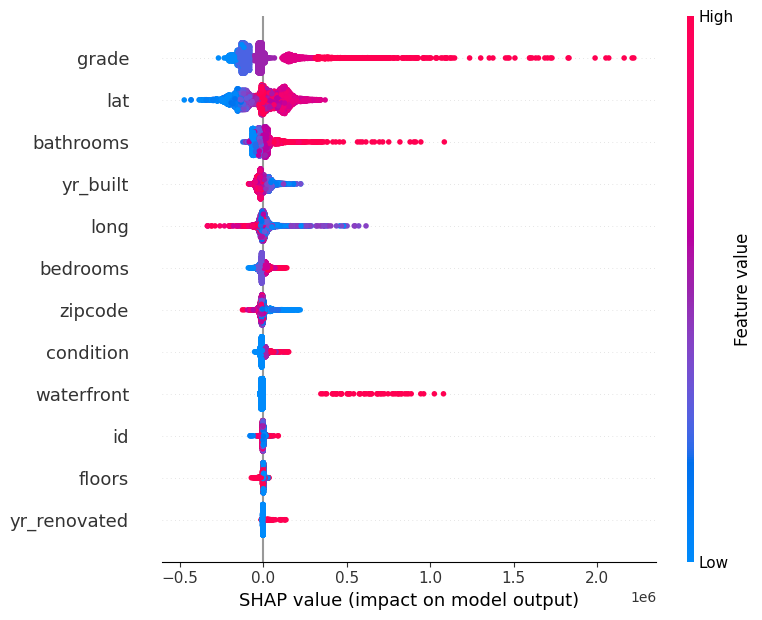

In [32]:
# summary
shap.summary_plot(shap_values, test_x)

#### 변수간 의존성 shap value
- 빨간 점이 최신일수록 파란점에 비해 많이 분포하기에, 최신 집일수록 grade가 높은 경향이 있다고 보여짐

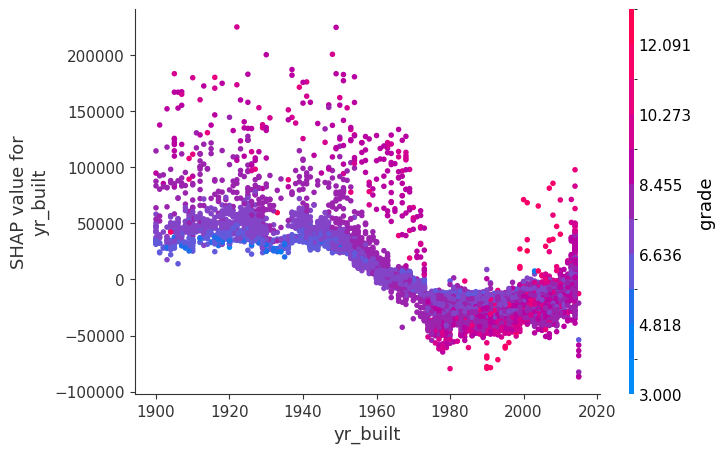

In [33]:
shap.dependence_plot("yr_built", shap_values, test_x)